# Minimal dummy example ictdeploy
## Creating a co-simulation graph
We considere the following two nodes graph as a minimal dummy example:

<img src="./figures/model.png" alt="Model" style="width: 500px;"/>

The above graph can be created in ictdeploy as follow:

In [1]:
import os
from ictdeploy import Simulator as Sim

In [2]:
#create empty simulator
sim = Sim()

In [3]:
#create Meta-model
sim.edit.add_meta(
        name="BaseMeta",
        set_attrs=["a"],
        get_attrs=["b"]
    )

'BaseMeta'

In [4]:
#create Model
sim.edit.add_model(
        name="BaseModel",
        meta="BaseMeta",
        image="integrcity/ict-simple",
        wrapper=os.path.join("wrappers", "base_wrap.py"),
        command=None,
        files=[os.path.join("files_to_add", "empty_file.txt")]
    )

'BaseModel'

Now that our `Meta-models` and `Models` have been created, we can populate our `Simulator` with `Nodes` as follow:

In [5]:
#add node
sim.edit.add_node(
        name="Base0",
        model="BaseModel",
        init_values={"c": 0.5},
        is_first=True
    )

'Base0'

In [6]:
#add node
sim.edit.add_node(
        name="Base1",
        model="BaseModel",
        init_values={"c": -0.25}
    )

'Base1'

And add `Links` between the created `Nodes` as follow:

In [7]:
sim.edit.add_link(get_node="Base0", get_attr="b", set_node="Base1", set_attr="a")
sim.edit.add_link(get_node="Base1", get_attr="b", set_node="Base0", set_attr="a")

## Data structure
The created co-simulation graph can be described by the following tables, gathering information about `Nodes` and `Links`.

In [8]:
sim.edit.nodes

,meta,model,to_set,to_get,image,wrapper,files,command,init_values,is_first
Base0,BaseMeta,BaseModel,[a],[b],integrcity/ict-simple,wrappers/base_wrap.py,[files_to_add/empty_file.txt],None,{'c': 0.5},True
Base1,BaseMeta,BaseModel,[a],[b],integrcity/ict-simple,wrappers/base_wrap.py,[files_to_add/empty_file.txt],None,{'c': -0.25},False


In [9]:
sim.edit.links

,get_attr,get_node,set_attr,set_node
0,b,Base0,a,Base1
1,b,Base1,a,Base0


The co-simulation graph can be ploted using `networkx` and `matplotlib` as follow:

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


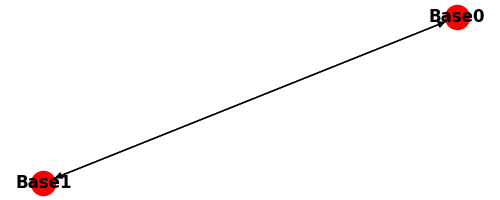

In [11]:
%matplotlib notebook
plt.figure(figsize=(5, 2))
g = sim.edit.graph
nx.draw(g, with_labels=True, font_weight='bold')

## Simulation parameters
Based on the created co-simulation graph, we can now create `Groups`, `Sequence` and `Steps` for the simulation as follow:

In [12]:
grp0 = sim.create_group("Base0")
grp1 = sim.create_group("Base1")

In [13]:
sim.create_sequence(grp0, grp1)
sim.create_steps([60] * 10)

## Running simulation
Everything is ready, we just have to run the simulation using `Simulator.run_simulation()`

In [14]:
logs = sim.run_simulation(server="server.py")
for l in sim.get_logs(logs["orc"]):
    if "INFO" in l:
        print(l)

INFO - 2018-04-03 07:51:58,629 - Connected to 172.17.01/obnl_vhost
INFO - 2018-04-03 07:51:58,640 - scheduler initialised.
INFO - 2018-04-03 07:51:59,216 - Simulator Base0 is connected.
INFO - 2018-04-03 07:51:59,498 - Simulator Base1 is connected.
INFO - 2018-04-03 07:51:59,498 - Start simulation.
INFO - 2018-04-03 07:51:59,596 - Simulation finished. Execution time: 0.09828829765319824 seconds


## Retrieving results
Now that the simulation is finished, we can connect to the database of results and list all the available stored values as follow:

In [15]:
sim.results.connect_to_results_db()
sim.results.list_of_available_results

,IN/OUT,Node,Attribute
0,IN,Base1,a
1,OUT,Base1,b
2,IN,Base0,a
3,OUT,Base0,b


Based on the preceding available stored values, we can choose wich results to get using a pattern matching the name of the selected values.

In [16]:
results = sim.results.get_results_by_pattern("OUT*")
results.keys()

dict_keys(['OUT_Base0_b', 'OUT_Base1_b'])

And finnaly, plot the selected results using `matplotlib`.

<IPython.core.display.Javascript object>


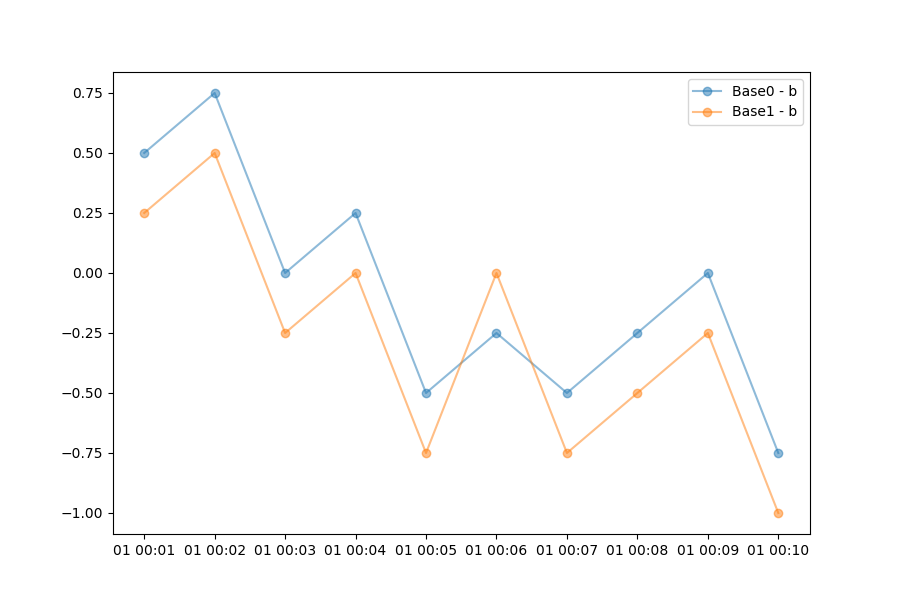

In [17]:
plt.figure(figsize=(9, 6))
plt.plot(results['OUT_Base0_b'], "-o", label="Base0 - b", alpha=0.5)
plt.plot(results['OUT_Base1_b'], "-o", label="Base1 - b", alpha=0.5)
plt.legend()